In [ ]:
#| default_exp data.tiling

# Tiling

> Tiling utilities for both raster and vector data

In [ ]:
#| hide
from nbdev.showdoc import *
import warnings
from fastcore.test import *

In [ ]:
#| hide
warnings.filterwarnings("ignore")

In [ ]:
#| export

import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
from fastcore.basics import *
import os
from pathlib import Path
from tqdm.auto import tqdm
import shapely
from shapely.geometry import box
import rasterio as rio
import rasterio.mask as rio_mask
import rasterio.windows as rio_windows
from rasterio.merge import merge as rio_merge
from sklearn.preprocessing import LabelEncoder
from geo2ml.data.postproc import *

Example area looks like this

In [ ]:
from rasterio import plot as rioplot
import matplotlib.pyplot as plt


In [ ]:
f = gpd.read_file('example_data/R70C21.shp')
f.head()
f['label_id'] = f.apply(lambda row: 2 if row.label == 'Standing' else 1, axis=1)
f.to_file('example_data/R70C21.shp')

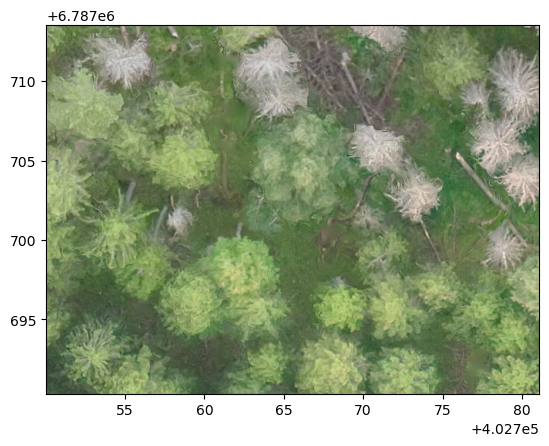

<Axes: >

In [ ]:
raster = rio.open('example_data/R70C21.tif')
rioplot.show(raster)

With `rasterio.plot` it is a lot easier to visualize shapefile and raster simultaneously

<Axes: >

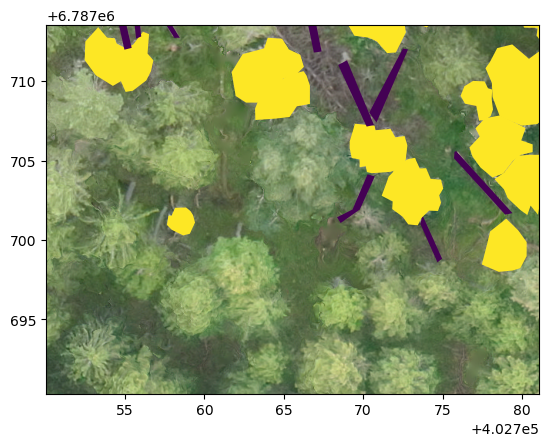

In [ ]:
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
f.plot(ax=ax, column='label_id')

## Tiling

In [ ]:
#| exporti

def fix_multipolys(multipoly:shapely.geometry.MultiPolygon):
    """Convert MultiPolygon to a single Polygon as coco and yolo don't work with polygons with holes in them.
    The resulting Polygon has the exterior boundaries of the largest geometry of the MultiPolygon"""
    temp_poly = None
    max_area = 0
    for geom in multipoly.geoms:
        area = geom.area
        if area > max_area:
            max_area = area
            temp_poly = geom
    return shapely.geometry.Polygon(temp_poly.exterior)

In [ ]:
#| export

class Tiler():
    """
    Handles the tiling of raster and vector data into smaller patches that each have the same coverage. 
    """
    def __init__(self, outpath, gridsize_x:int=400, gridsize_y:int=400, 
                 overlap:tuple[int, int]=(100, 100)):
        store_attr()
        self.grid = None
        if not os.path.exists(outpath): os.makedirs(outpath)
        self.outpath = Path(self.outpath)
        self.raster_path = self.outpath/'images'
        self.vector_path = self.outpath/'vectors'
        self.rasterized_vector_path = self.outpath/'rasterized_vectors'
    
    def tile_raster(self, path_to_raster:str, allow_partial_data:bool=False) -> None:
        "Tiles specified raster to `self.gridsize_x` times `self.gridsize_y` grid, with `self.overlap` pixel overlap"
        names = []
        polys = []
        col_id = 0
        row_id = 0
        
        if not os.path.exists(self.raster_path): os.makedirs(self.raster_path)
        with rio.open(path_to_raster) as src:
            y, x = src.shape
            for (iy, dy), (ix, dx) in tqdm(itertools.product(enumerate(range(0, y, self.gridsize_y-self.overlap[1])), 
                                                             enumerate(range(0, x, self.gridsize_x-self.overlap[0])))):
                
                if dy+self.gridsize_y > y and not allow_partial_data: continue
                if dx+self.gridsize_x > x and not allow_partial_data: continue
                window = rio_windows.Window.from_slices((dy, dy+self.gridsize_y),
                                                        (dx, dx+self.gridsize_x))
                prof = src.profile.copy()
                
                prof.update(
                    height=window.height,
                    width=window.width,
                    transform= rio_windows.transform(window, src.transform),
                    compress='lzw',
                    predictor=2
                )
                fname = f'R{iy}C{ix}'
                data = src.read(window=window)
                if data.shape[1] < window.height or data.shape[2] < window.width:
                    newdata = np.zeros((data.shape[0], window.height, window.width))
                    newdata[:, :data.shape[1], :data.shape[2]] = data
                    data = newdata
                with rio.open(f'{self.raster_path}/{fname}.tif', 'w', **prof) as dest:
                    dest.write(data)
                    polys.append(box(*dest.bounds))
                names.append(fname)
            self.grid = gpd.GeoDataFrame({'cell': names, 'geometry':polys}, crs=src.crs)  
        return
    
    def tile_vector(self, path_to_vector:str, min_area_pct:float=0.0, gpkg_layer:str=None) -> None:
        """
        Tiles a vector data file into smaller tiles. Converts all multipolygons to a regular polygons. `min_area_pct` is be used to specify the minimum area for partial masks to keep. Default value 0.0 keeps all masks.
        """
        if self.grid is None:
            raise Exception(
                'No raster grid specified, use Tiler.tile_raster to determine grid limits'
            )
            
        if path_to_vector.endswith('.gpkg') and not gpkg_layer:
            raise Exception(
               '`sampling_locations` is .gpkg but no `gpkg_layer` specified'
            )
        
        if not os.path.exists(self.vector_path): os.makedirs(self.vector_path)

        vector = gpd.read_file(path_to_vector, layer=gpkg_layer)

        sindex = vector.sindex
        for row in tqdm(self.grid.itertuples()):
            possible_matches_index = list(sindex.intersection(row.geometry.bounds))
            tempvector = vector.iloc[possible_matches_index].copy()
            tempvector['orig_area'] = tempvector.geometry.area
            tempvector = tempvector.clip(row.geometry, keep_geom_type=True)

            if min_area_pct < 0 or min_area_pct > 1:
                print('Invalid minimum area percentage set, defaulting to 0')
            tempvector = tempvector[tempvector.geometry.area >= tempvector.orig_area * min_area_pct]
            # No annotations -> no output file
            if len(tempvector) == 0: continue            
            tempvector['geometry'] = tempvector.apply(lambda row: fix_multipolys(row.geometry) 
                                                      if row.geometry.geom_type == 'MultiPolygon'
                                                      else shapely.geometry.Polygon(row.geometry.exterior), axis=1)

            tempvector.to_file(f'{self.vector_path}/{row.cell}.geojson', driver='GeoJSON')
        return
    
    def tile_and_rasterize_vector(self, path_to_raster:str, path_to_vector:str, column:str,
                                  gpkg_layer:str=None, keep_bg_only:bool=False) -> None:
        """Rasterizes vectors based on tiled rasters. Saves label map to `self.outpath`. By default only keeps the patches that contain polygon data, by specifying `keep_bg_only=True` saves also masks for empty patches."""
            
        if self.grid is None:
            raise Exception(
                'No raster grid specified, use Tiler.tile_raster to determine grid limits'
            )
            

        if path_to_vector.endswith('.gpkg') and not gpkg_layer:
            raise Exception(
               '`sampling_locations` is .gpkg but no `gpkg_layer` specified'
            )
        
        
        if not os.path.exists(self.rasterized_vector_path): os.makedirs(self.rasterized_vector_path)

        vector = gpd.read_file(path_to_vector)
        le = LabelEncoder()
        vector['label'] = le.fit_transform(vector[column].values) + 1 # We want the labels to start from 1 as 0 is background most of the time
        with open(self.outpath/'label_map.txt', 'w') as f:
            for c, i in zip(le.classes_, le.transform(le.classes_)):
                f.write(f'{c}: {i+1}\n')
        for r in tqdm(os.listdir(self.raster_path)):
            with rio.open(self.raster_path/r) as src:
                out_meta = src.meta
                out_meta.update({'count':1})
                tempvector = vector.clip(box(*src.bounds), keep_geom_type=False)

                with rio.open(self.rasterized_vector_path/r, 'w+', **out_meta) as dest:
                    dest_arr = dest.read(1)
                    if len(tempvector) == 0: 
                        if keep_bg_only: dest.write_band(1, dest_arr)
                        continue
                    shapes = ((geom,value) for geom, value in zip(tempvector.geometry, tempvector['label']))
                    burned = rio.features.rasterize(shapes=shapes, fill=0, out=dest_arr, transform=dest.transform)
                    dest.write_band(1, burned)   
        return

In [ ]:
tiler = Tiler(outpath='example_data/tiles', gridsize_x=240, gridsize_y=180, overlap=(120, 90))

In [ ]:
#| hide

# tests
test_fail(tiler.tile_and_rasterize_vector, args=('example_data/R70C21.tif', 'example_data/R70C21.shp', 'label'))
test_fail(tiler.tile_vector, args=('example_data/R70C21.gpkg', .2))

In [ ]:
show_doc(Tiler.tile_raster)

---

[source](https://github.com/mayrajeo/geo2ml/blob/main/geo2ml/data/tiling.py#L60){target="_blank" style="float:right; font-size:smaller"}

### Tiler.tile_raster

>      Tiler.tile_raster (path_to_raster:str, allow_partial_data:bool=False)

Tiles specified raster to `self.gridsize_x` times `self.gridsize_y` grid, with `self.overlap` pixel overlap

In [ ]:
tiler.tile_raster('example_data/R70C21.tif')

0it [00:00, ?it/s]

In [ ]:
show_doc(Tiler.tile_vector)

---

[source](https://github.com/mayrajeo/geo2ml/blob/main/geo2ml/data/tiling.py#L110){target="_blank" style="float:right; font-size:smaller"}

### Tiler.tile_vector

>      Tiler.tile_vector (path_to_vector:str, min_area_pct:float=0.0,
>                         gpkg_layer:str=None)

Tiles a vector data file into smaller tiles. Converts all multipolygons to a regular polygons. `min_area_pct` is be used to specify the minimum area for partial masks to keep. Default value 0.0 keeps all masks.

In [ ]:
#| hide

# tests
test_fail(tiler.tile_vector, args=('example_data/R70C21.gpkg', .2))

In [ ]:
tiler.tile_vector('example_data/R70C21.shp', min_area_pct=.2)

0it [00:00, ?it/s]

In [ ]:
show_doc(Tiler.tile_and_rasterize_vector)

---

[source](https://github.com/mayrajeo/geo2ml/blob/main/geo2ml/data/tiling.py#L151){target="_blank" style="float:right; font-size:smaller"}

### Tiler.tile_and_rasterize_vector

>      Tiler.tile_and_rasterize_vector (path_to_raster:str, path_to_vector:str,
>                                       column:str, gpkg_layer:str=None,
>                                       keep_bg_only:bool=False)

Rasterizes vectors based on tiled rasters. Saves label map to `self.outpath`. By default only keeps the patches that contain polygon data, by specifying `keep_bg_only=True` saves also masks for empty patches.

In [ ]:
#| hide

# tests
test_fail(tiler.tile_and_rasterize_vector, args=('example_data/R70C21.tif', 'example_data/R70C21.gpkg', 'label'))

In [ ]:
tiler.tile_and_rasterize_vector('example_data/R70C21.tif', 'example_data/R70C21.shp', 
                                column='label')

0it [00:00, ?it/s]

In [ ]:
tiler.tile_and_rasterize_vector('example_data/R70C21.tif', 'example_data/R70C21.shp', 
                                column='label', keep_bg_only=True)

0it [00:00, ?it/s]

<matplotlib.image.AxesImage>

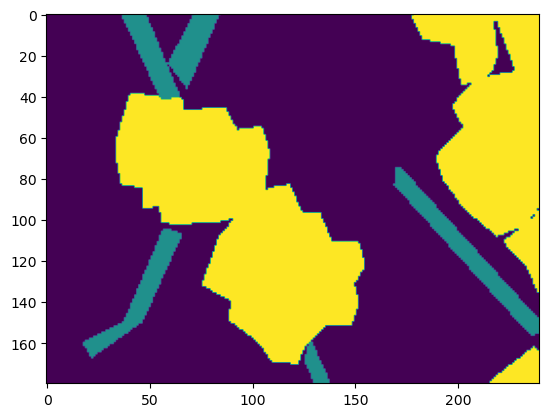

In [ ]:
with rio.open('example_data/tiles/rasterized_vectors/R1C3.tif') as i: im = i.read()
plt.imshow(im[0])

## Reversing the tiling

In [ ]:
#| export

def untile_raster(path_to_targets:str, outfile:str, method:str='first'):
    """Merge multiple patches from `path_to_targets` into a single raster`"""

    rasters = [f'{path_to_targets}/{f}' for f in os.listdir(path_to_targets) if f.endswith('.tif')]
    
    if method == 'sum': method = copy_sum
    
    files_to_mosaic = []
       
    for f in rasters:
        src = rio.open(f)
        files_to_mosaic.append(src)
    
    mosaic, out_tfm = rio_merge(files_to_mosaic, method=method)
    
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_tfm,
                     'crs': src.crs})
    
    with rio.open(outfile, 'w', **out_meta) as dest: dest.write(mosaic)
    
def copy_sum(merged_data, new_data, merged_mask, new_mask, **kwargs):
    "Make new pixels have the sum of two overlapping pixels as their value. Useful with prediction data"
    newregion = merged_data + new_data
    np.copyto(merged_data, newregion)    
    
def untile_vector(path_to_targets:str, outpath:str, non_max_suppression_thresh:float=0.0, nms_criterion:str='score'):
    "Create single shapefile from a directory of predicted .shp or .geojson files"
    pred_files = [f for f in os.listdir(path_to_targets) if f.endswith(('.shp', '.geojson'))]
    gdf = None
    for p in tqdm(pred_files):
        temp_gdf = gpd.read_file(f'{path_to_targets}/{p}')
        if gdf is None: gdf = temp_gdf
        else: gdf = pd.concat((gdf,temp_gdf))
    print(f'{len(gdf)} polygons before non-max suppression')
    if non_max_suppression_thresh != 0:
        np_bounding_boxes = np.array([b.bounds for b in gdf.geometry])
        scores = gdf.score.values
        idxs = non_max_suppression_fast(np_bounding_boxes, scores, 
                                        overlap_thresh=non_max_suppression_thresh,
                                        sort_criterion=nms_criterion)
        gdf = gdf.iloc[idxs]
    print(f'{len(gdf)} polygons after non-max suppression')
    if outpath.endswith('shp'):
        gdf.to_file(outpath)
    elif outpath.endswith('geojson'):
        gdf.to_file(outpath, driver='GeoJSON')
    return

Untile shapefiles and check how they look

In [ ]:
untile_vector(f'example_data/tiles/vectors', outpath='example_data/untiled.geojson')

  0%|          | 0/21 [00:00<?, ?it/s]

81 polygons before non-max suppression
81 polygons after non-max suppression


Plot with the tiled grid.

<Axes: >

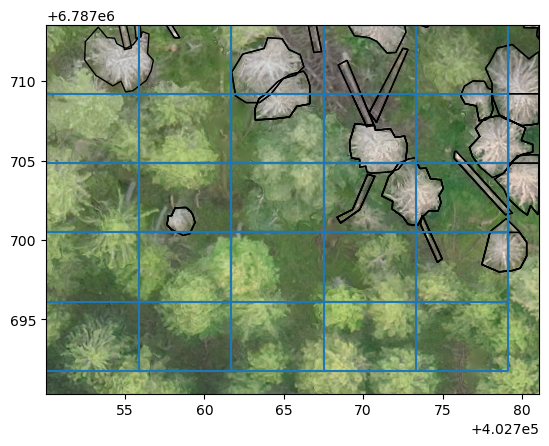

In [ ]:
untiled = gpd.read_file('example_data/untiled.geojson')
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
tiler.grid.exterior.plot(ax=ax)
untiled.plot(ax=ax, column='label_id', facecolor='none', edgecolor='black')

If `allow_partial_data=False` as is the default behaviour, tiling is done only for the area from which full sized patch can be extracted. With `allow_partial_data=True`, windows can "extend" to empty areas. This is useful with inference, when predicted areas can have wonky dimensions.

In [ ]:
tiler.tile_raster('example_data/R70C21.tif', allow_partial_data=True)

0it [00:00, ?it/s]

In [ ]:
tiler.tile_vector('example_data/R70C21.shp', min_area_pct=.2)

0it [00:00, ?it/s]

Untile shapefiles and check how they look

In [ ]:
untile_vector(f'example_data/tiles/vectors', outpath='example_data/untiled.geojson')

  0%|          | 0/21 [00:00<?, ?it/s]

81 polygons before non-max suppression
81 polygons after non-max suppression


<Axes: >

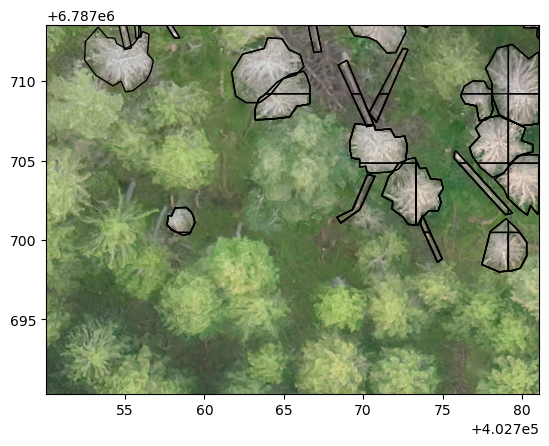

In [ ]:
untiled = gpd.read_file('example_data/untiled.geojson')
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
untiled.plot(ax=ax, column='label_id', facecolor='none', edgecolor='black')

Plot with the tiled grid.

<Axes: >

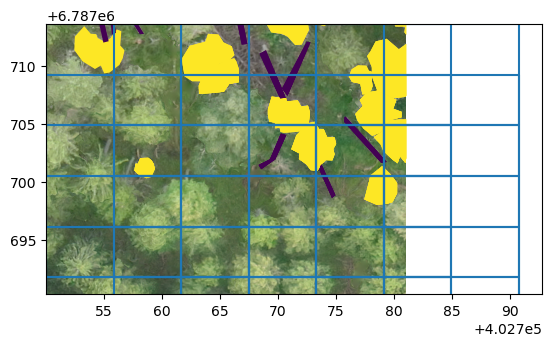

In [ ]:
untiled = gpd.read_file('example_data/untiled.geojson')
fig, ax = plt.subplots(1,1)
rioplot.show(raster, ax=ax)
tiler.grid.exterior.plot(ax=ax)
untiled.plot(ax=ax, column='label_id')

`untile_raster` can be used to mosaic all patches into one.

In [ ]:
untile_raster('example_data/tiles/rasterized_vectors/', 'example_data/tiles/mosaic_first.tif', 
              method='first')

<matplotlib.image.AxesImage>

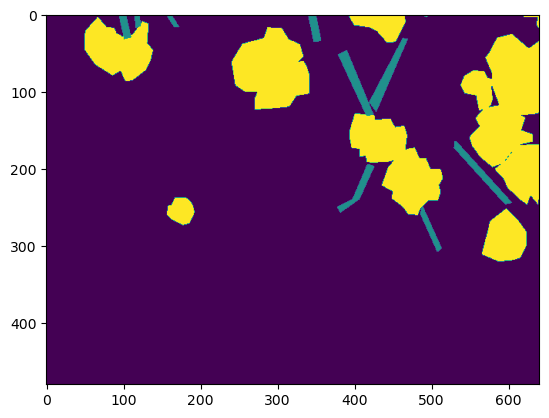

In [ ]:
with rio.open('example_data/tiles/mosaic_first.tif') as mos: mosaic = mos.read()
plt.imshow(mosaic[0])

By specifying method as sum it's possible to collate predictions and get the most likely label for pixels

In [ ]:
untile_raster('example_data/tiles/rasterized_vectors/', 'example_data/tiles/mosaic_sum.tif',
              method='sum')

<matplotlib.image.AxesImage>

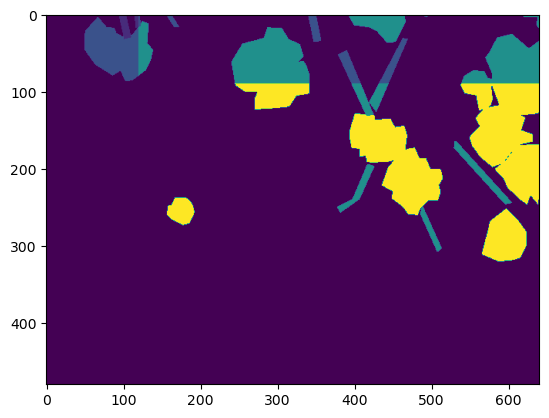

In [ ]:
with rio.open('example_data/tiles/mosaic_sum.tif') as mos: mosaic = mos.read()
plt.imshow(mosaic[0])

In [ ]:
#| hide

from nbdev import nbdev_export
nbdev_export()